In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from instron_processing import ureg, Q_
import instron_processing.instron_processing as ip
import pint
import pint_pandas

ureg = pint.get_application_registry()
ureg.setup_matplotlib()
ureg.formatter.default_format = 'P~'
ureg.mpl_formatter = "{:~P}"

# Homogeneous Samples

The v2 versions of the homogeneous samples are the ones we went forward with, which gives us ~30:1 stiffness ratio in the XY-plane

In [46]:
dense_v1 = ip.load_samples('./homogeneous_foams/250309',
                           lambda f: 'dense' in f.stem.lower() and 'v1' in f.stem.lower())
sparse_v1 = ip.load_samples('./homogeneous_foams/250309',
                            lambda f: 'sparse' in f.stem.lower() and 'v1' in f.stem.lower())
dense_v2 = ip.load_samples('./homogeneous_foams/250309',
                           lambda f: 'dense' in f.stem.lower() and 'v2' in f.stem.lower())
sparse_v2 = ip.load_samples('./homogeneous_foams/250309',
                            lambda f: 'sparse' in f.stem.lower() and 'v2' in f.stem.lower())


samples = [dense_v1, sparse_v1, dense_v2, sparse_v2]

for group in samples:
    for s in group:
        s.user_data = dict(
            comp_dir=s.results_tables[0]['Compression Axis'],
            width=s.results_tables[0]['Width'],
            height=s.results_tables[0]['Height'],
            thickness=s.results_tables[0]['Thickness'],
        )
        s.data['Calculated compressive strain (Displacement)'] = (s.data['Compressive displacement'] /
                                                                  s.user_data['thickness']).pint.to('%')
        s.data['Calculated compressive stress'] = (s.data['Force'] /
                                                   s.user_data['width'] / s.user_data['thickness']).pint.to('kPa')
        m, b = s.add_linear_fit(x='Compressive strain (Displacement)',
                                y='Compressive stress',
                                x_min=1.*ureg.percent,
                                x_max=10. * ureg.percent)
        s.user_data |= dict(
            E=m.to('MPa'),
            y_intercept=b,
        )

Loading csv files from ./homogeneous_foams/250309
9 found that match the filter
Loading csv files from ./homogeneous_foams/250309
9 found that match the filter
Loading csv files from ./homogeneous_foams/250309
9 found that match the filter
Loading csv files from ./homogeneous_foams/250309
9 found that match the filter


In [ ]:
# Define sample types and directions
sample_types = ['dense_v1', 'sparse_v1', 'dense_v2', 'sparse_v2']
directions = ['X', 'Y', 'Z']
nrows = len(sample_types)
ncols = len(directions)

# Create a structured array to organize samples
organized_samples = np.empty((nrows, ncols), dtype=object)
for i in range(nrows):
    for j in range(ncols):
        organized_samples[i, j] = []

# Fill the array with samples
for i, group in enumerate(samples):
    for sample in group:
        dir_name = sample.user_data['comp_dir']
        dir_idx = {'X': 0, 'Y': 1, 'Z': 2}.get(
            dir_name, 0)  # Default to X if unknown
        organized_samples[i, dir_idx].append(sample)

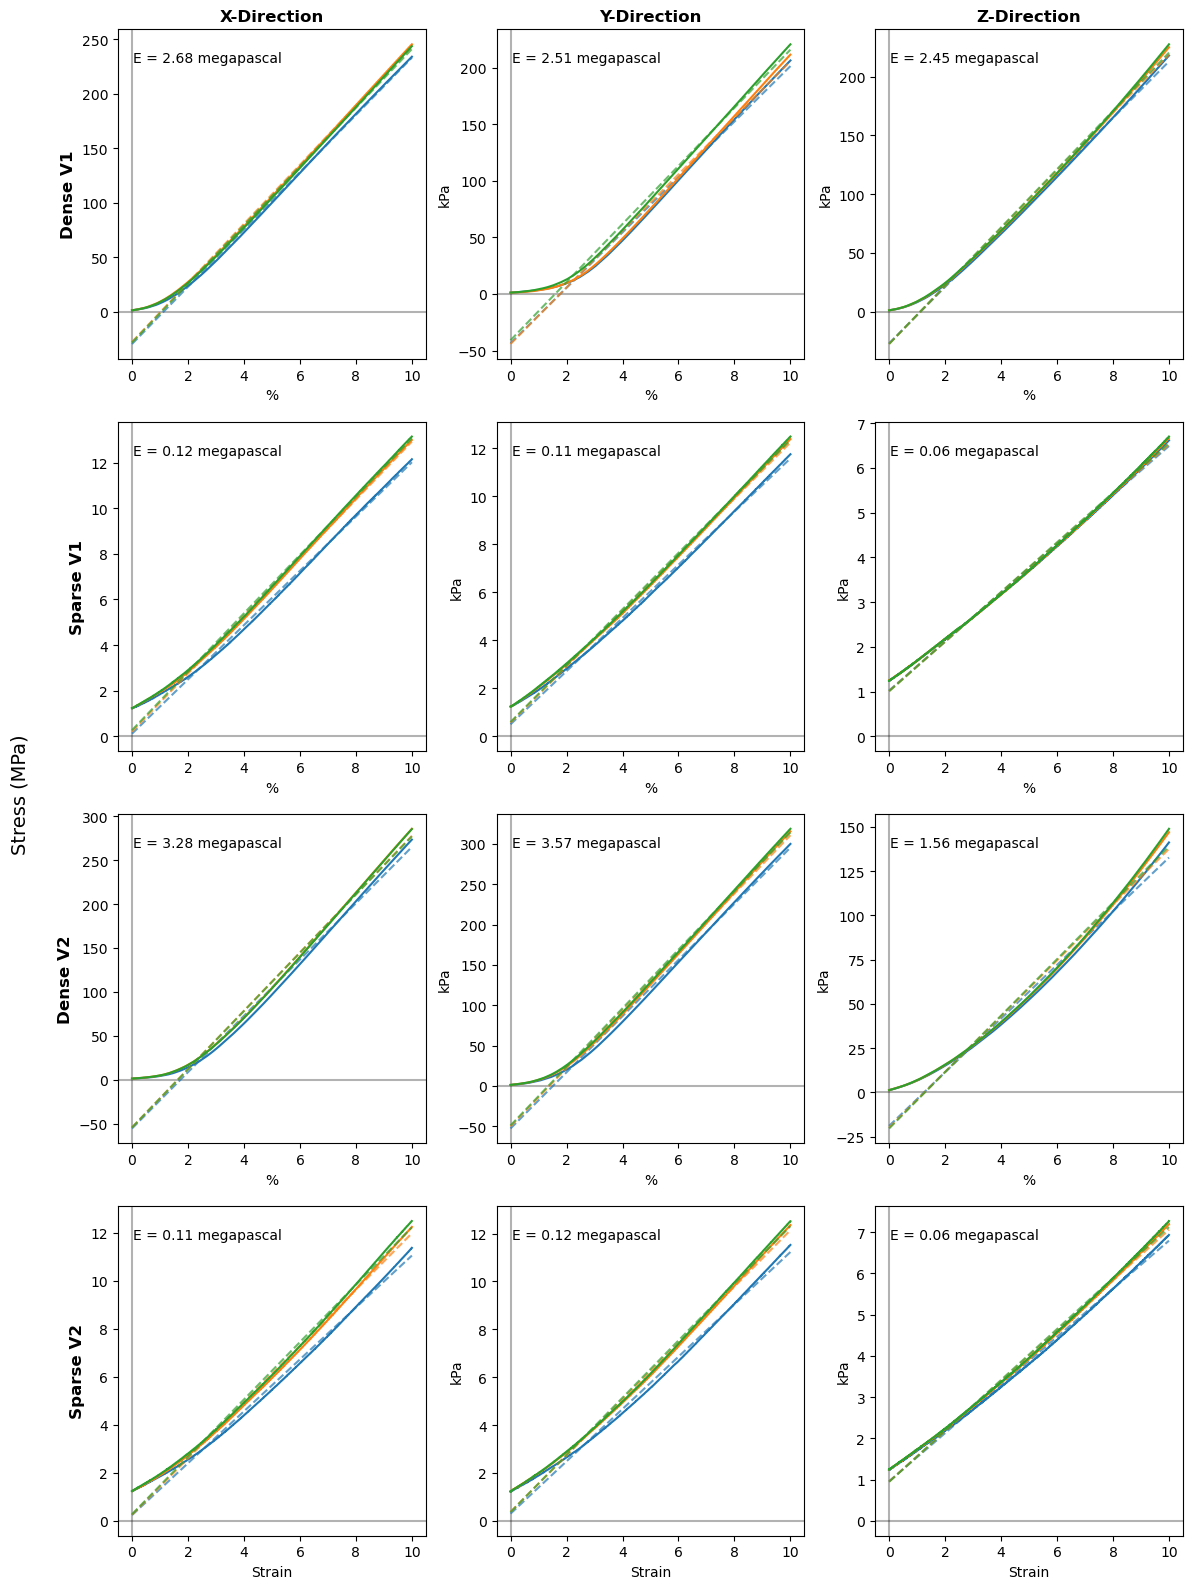

In [ ]:
# Data to plot
x_col = 'Compressive strain (Displacement)'
y1_col = 'Compressive stress'
y2_col = 'Compressive stress (Line Fit)'
# y2_col = 'Calculated compressive stress'
# x bounds of plot
strain_limits = (0., 0.1)

# Plotting
fig, axg = plt.subplots(4, 3, figsize=(12, 16))

# Add titles for columns (directions)
for j, direction in enumerate(directions):
    axg[0, j].set_title(f'{direction}-Direction', fontweight='bold')

# Add row labels (sample types)
for i, sample_type in enumerate(sample_types):
    # Create a more readable label
    label = sample_type.replace('_', ' ').title()
    axg[i, 0].set_ylabel(label, fontweight='bold', rotation=90, size=12)

# Plot data
for i in range(4):
    for j in range(3):
        ax = axg[i, j]
        ax.axvline(color='k', alpha=0.3)
        ax.axhline(color='k', alpha=0.3)

        # Plot each sample in this category
        samples_to_plot = organized_samples[i, j]
        for k, sample in enumerate(samples_to_plot):
            # Apply strain limits
            mask = ((sample.data[x_col] >= strain_limits[0]) &
                    (sample.data[x_col] <= strain_limits[1]))

            # Plot raw data
            ax.plot(sample.data[x_col][mask],
                    sample.data[y1_col][mask],
                    label=f'Sample {k+1}')

            # Plot linear fit if available
            if y2_col in sample.data.columns:
                ax.plot(sample.data[x_col][mask],
                        sample.data[y2_col][mask],
                        linestyle='--',
                        color=ax.lines[-1].get_color(),
                        alpha=0.7)

        # Add E value as text in each subplot
        if samples_to_plot:
            E_values = [s.user_data['E'] for s in samples_to_plot]
            avg_E = sum(E_values)/len(E_values) if E_values else 0
            ax.text(0.05, 0.9, f'E = {avg_E:.2f}', transform=ax.transAxes)

        # Set common x and y limits
        # ax.set_xlim(strain_limits * ureg.percent)

        # Only add x-labels to bottom row
        if i == 3:
            ax.set_xlabel('Strain')

# Add a common y-label
fig.text(0.01, 0.5, 'Stress (MPa)', va='center',
         rotation='vertical', fontsize=14)

plt.tight_layout()
plt.subplots_adjust(left=0.1)  # Make room for common y-label

# # Add a small legend to the bottom right subplot only
# if organized_samples[3, 2]:  # If there are samples in the bottom right
#     axg[3, 2].legend(loc='upper left', fontsize='small')

# Foam Metamaterials

These materials were topology optimized with the v2 parameters:
- Dense $V^*/H^*$: 0.15/6.93
- Sparse $V^*/H^*$: 0.4/14.81

## 1467 BULK m2

Two different versions. One printed with a 2 mm transition and one printed with a 0 mm transition

In [54]:
DATA_DIR = "./metamaterials"

In [70]:
BULK_m2_2mmTransition = ip.load_samples(DATA_DIR,
                                        filter_fn=lambda f: '2mm' in f.stem.lower())
BULK_m2_NoTransition = ip.load_samples(DATA_DIR,
                                       filter_fn=lambda f: 'no' in f.stem.lower())

samples = [BULK_m2_2mmTransition, BULK_m2_NoTransition]

strain_limits = (0., 0.05)
for group in samples:
    for s in group:
        s.user_data = dict(
            comp_dir=s.results_tables[0]['Compression Axis'],
            width=150 * ureg.mm,
            height=150 * ureg.mm,
            thickness=28 * ureg.mm
        )
        s.data['Calculated compressive strain'] = (s.data['Compressive displacement'] /
                                                   s.user_data['height']).pint.to('%')
        s.data['Calculated compressive stress'] = s.data['Force'] / \
            s.user_data['thickness'] / s.user_data['width']
        m, b = s.add_linear_fit(x='Compressive strain (Displacement)',
                                y='Compressive stress',
                                x_min=strain_limits[0],
                                x_max=strain_limits[1])
        s.user_data |= dict(
            E=m.to('MPa'),
            y_intercept=b,
        )

Loading csv files from ./metamaterials
6 found that match the filter
Loading csv files from ./metamaterials
6 found that match the filter


In [ ]:
sample_types = ['2mm_Transition', 'No_Transition']
directions = ['X', 'Y']
nrows = len(sample_types)
ncols = len(directions)

organized_samples = np.empty((nrows, ncols), dtype=object)
for i in range(nrows):
    for j in range(ncols):
        organized_samples[i, j] = []

for i, group in enumerate(samples):
    for sample in group:
        dir_name = sample.user_data['comp_dir']
        dir_idx = {'X': 0, 'Y': 1}.get(dir_name, 0)
        organized_samples[i, dir_idx].append(sample)

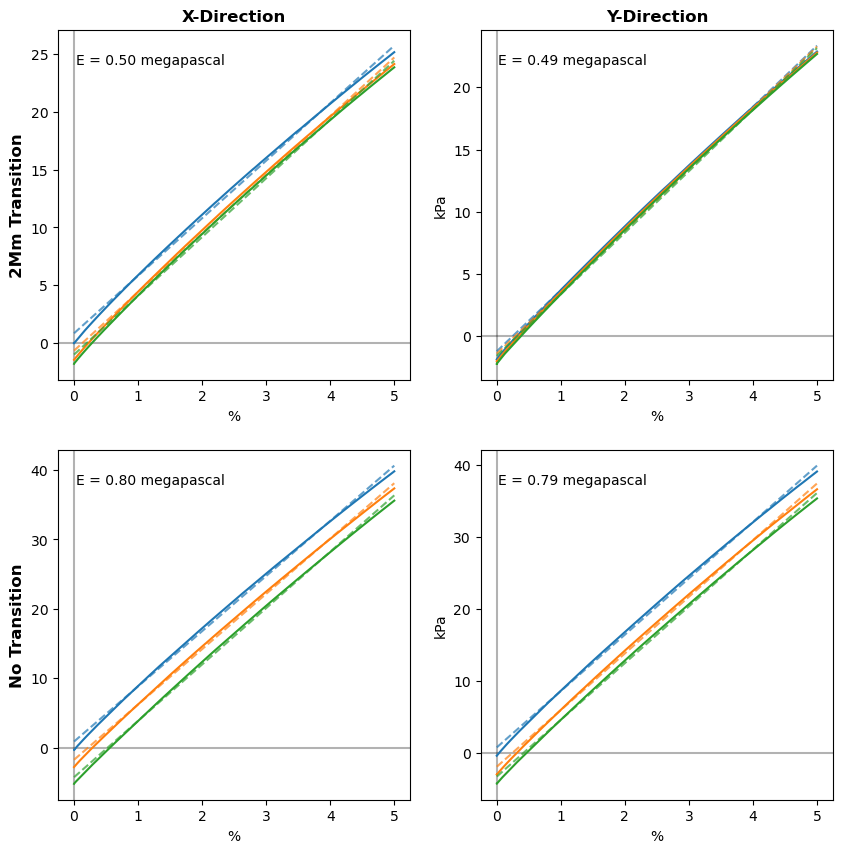

In [ ]:
# Data to plot
x_col = 'Compressive strain (Displacement)'
y1_col = 'Compressive stress'
y2_col = 'Compressive stress (Line Fit)'
# y2_col = 'Calculated compressive stress'

fig, axg = plt.subplots(nrows, ncols, figsize=(10, 10))

for j, direction in enumerate(directions):
    axg[0, j].set_title(f'{direction}-Direction', fontweight='bold')

for i, sample_type in enumerate(sample_types):
    label = sample_type.replace('_', ' ').title()
    axg[i, 0].set_ylabel(label, fontweight='bold', rotation=90, size=12)

for i in range(nrows):
    for j in range(ncols):
        ax = axg[i, j]
        ax.axvline(color='k', alpha=0.3)
        ax.axhline(color='k', alpha=0.3)

        samples_to_plot = organized_samples[i, j]
        for k, sample in enumerate(samples_to_plot):
            mask = ((sample.data[x_col] >= strain_limits[0]) &
                    (sample.data[x_col] <= strain_limits[1]))

            ax.plot(sample.data[x_col][mask],
                    sample.data[y1_col][mask],
                    label=f'Sample {k+1}')

            if y2_col in sample.data.columns:
                ax.plot(sample.data[x_col][mask],
                        sample.data[y2_col][mask],
                        linestyle='--',
                        color=ax.lines[-1].get_color(),
                        alpha=0.7)

        if samples_to_plot:
            E_values = [s.user_data['E'] for s in samples_to_plot]
            avg_E = sum(E_values)/len(E_values) if E_values else 0.
            ax.text(0.05, 0.9, f'E = {avg_E:.2f}', transform=ax.transAxes)

    if i == 2:
        ax.set_xlabel('Strain')

## 1049 VERT m1

These samples do not have any transition

In [ ]:
VERT_1049_m1_samples = ip.load_samples(DATA_DIR,
                                       filter_fn=lambda f: 'vert' in f.stem.lower())
strain_limits = (0, 0.025)

for sample in VERT_1049_m1_samples:
    sample.user_data = dict(
        comp_dir=sample.results_tables[0]['Compresson Axis'],
        height=150 * ureg.mm,
        width=150 * ureg.mm,
        thickness=28 * ureg.mm,
    )
    sample.data['Calculated compressive strain'] = sample.data['Compressive displacement'] / \
        sample.user_data['height']
    sample.data['Calculated compressive stress'] = sample.data['Force'] / \
        sample.user_data['width'] / sample.user_data['thickness']
    m, b = sample.add_linear_fit(x='Compressive strain (Displacement)',
                                 y='Compressive stress',
                                 x_min=strain_limits[0],
                                 x_max=strain_limits[1])
    sample.user_data |= dict(
        E=m.to('MPa'),
        y_intercept=b,
    )

Loading csv files from ./metamaterials
6 found that match the filter


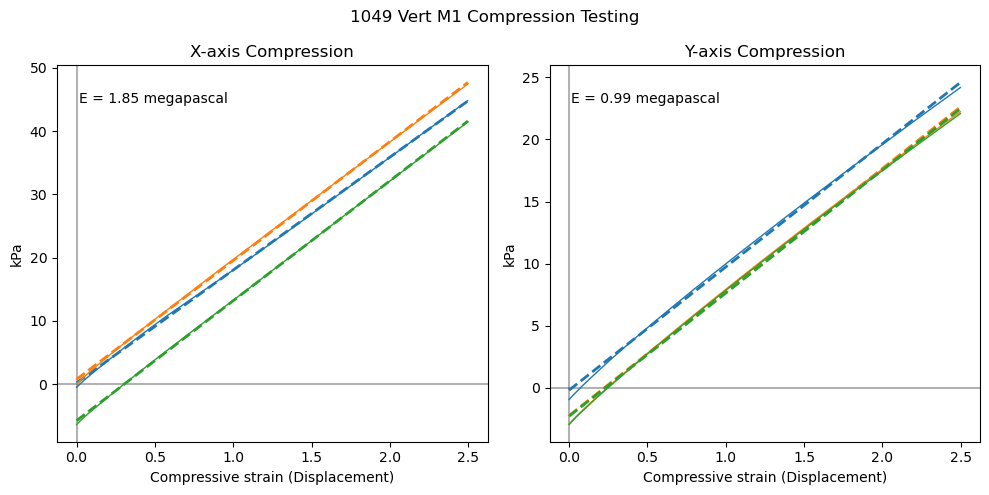

In [103]:
# Data to plot
x_col = 'Compressive strain (Displacement)'
y1_col = 'Compressive stress'
y2_col = 'Compressive stress (Line Fit)'
# y2_col = 'Calculated compressive stress'
# x bounds of plot

comp_dirs = ['X', 'Y']

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for comp_dir, ax in zip(comp_dirs, axs):
    samples_to_plot = [
        s for s in VERT_1049_m1_samples if s.user_data['comp_dir'] == comp_dir]
    ax.axvline(color='k', alpha=0.3)
    ax.axhline(color='k', alpha=0.3)
    for sample in samples_to_plot:
        sample.plot(x=x_col, y=y1_col, ax=ax, lw=1,
                    x_min=strain_limits[0], x_max=strain_limits[1], legend=False)
        sample.plot(x=x_col, y=y2_col, ax=ax, lw=2,
                    x_min=strain_limits[0], x_max=strain_limits[1], ls='--', color=ax.lines[-1].get_color(), legend=False)
        ax.set_title(f'{comp_dir}-axis Compression')

    if samples_to_plot:
        Es = [s.user_data['E'] for s in samples_to_plot]
        avg_E = sum(Es) / len(Es) if Es else 0.
        ax.text(0.05, 0.9, f'E = {avg_E:.2f}', transform=ax.transAxes)

fig.suptitle('1049 VERT m1 Compression Testing'.title())
plt.tight_layout()

## 2046 BULK m1

These samples do not have any transition

In [ ]:
BULK_2046_m1_samples = ip.load_samples(DATA_DIR,
                                       filter_fn=lambda f: '2246' in f.stem.lower())
strain_limits = (0, 0.025)

for s in BULK_2046_m1_samples:
    s.user_data = dict(
        comp_dir=s.results_tables[0]['Compresson Axis'],
        height=150*ureg.mm,  # s.results_tables[0]['Height'],
        width=150*ureg.mm,  # s.results_tables[0]['Width'],
        thickness=28*ureg.mm  # s.results_tables[0]['Thickness']
    )
    s.data['Calculated compressive strain'] = s.data['Compressive displacement'] / \
        s.user_data['height']
    s.data['Calculated compressive stress'] = s.data['Force'] / \
        s.user_data['width'] / s.user_data['thickness']
    m, b = s.add_linear_fit(x='Compressive strain (Displacement)',
                            y='Compressive stress',
                            x_min=strain_limits[0],
                            x_max=strain_limits[1])
    s.user_data |= dict(
        E=m.to('MPa'),
        y_intercept=b,
    )

Loading csv files from ./metamaterials
6 found that match the filter


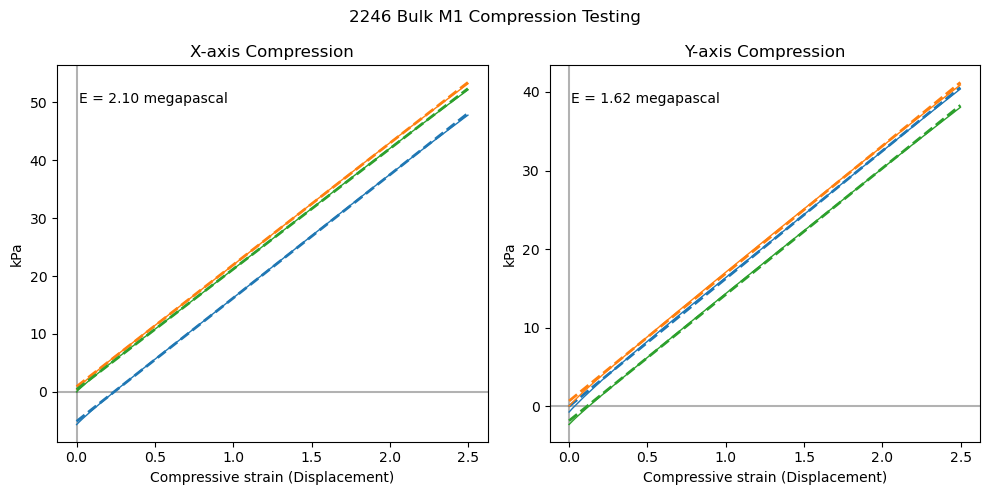

In [ ]:
# Data to plot
x_col = 'Compressive strain (Displacement)'
y1_col = 'Compressive stress'
y2_col = 'Compressive stress (Line Fit)'
# y2_col = 'Calculated compressive stress'

comp_dirs = ('X', 'Y')

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for comp_dir, ax in zip(comp_dirs, axs):
    samples_to_plot = [
        s for s in BULK_2046_m1_samples if s.user_data['comp_dir'] == comp_dir]
    ax.axvline(color='k', alpha=0.3)
    ax.axhline(color='k', alpha=0.3)
    for sample in samples_to_plot:
        sample.plot(x=x_col, y=y1_col, lw=1,
                    x_min=strain_limits[0], x_max=strain_limits[1], ax=ax, legend=False)
        sample.plot(x=x_col, y=y2_col,
                    x_min=strain_limits[0], x_max=strain_limits[1], ax=ax, lw=2, ls='--', color=ax.lines[-1].get_color(), legend=False)
        ax.set_title(f'{comp_dir}-axis Compression')

    if samples_to_plot:
        Es = [s.user_data['E'] for s in samples_to_plot]
        avg_E = sum(Es) / len(Es) if Es else 0.
        ax.text(0.05, 0.9, f'E = {avg_E:.2f}', transform=ax.transAxes)

fig.suptitle('2246 BULK m1 Compression Testing'.title())
plt.tight_layout()

# Post-Experiment Material Parameter Fitting

Here we use the measured moduli values as a check on the simulated data, doing a post-experimental fit of what the effective modulus ratio is since the data doesn't match the simulated.

In [41]:
from incense import ExperimentLoader
from incense.artifact import PickleArtifact
from metatop.Metamaterial import setup_metamaterial
from metatop.optimization.OptimizationState import OptimizationState
from metatop.filters import setup_filter, jax_projection
from metatop.mechanics import calculate_elastic_constants, mandelize
from metatop import V_DICT
from copy import deepcopy
from scipy.optimize import minimize
from scipy.optimize import differential_evolution

# function definitions


def filter_and_project(ops, x):
    x = ops.filt_fn(x)
    return jax_projection(x, ops.beta, ops.eta)


def setup(exp_dict, loader, inplace=False):
    if inplace:
        _exp_dict = exp_dict
    else:
        _exp_dict = deepcopy(exp_dict)

    for id in _exp_dict.keys():
        exp = loader.find_by_id(id)
        config = exp.to_dict()['config']
        for k, v in exp.artifacts.items():
            if '.pkl' in k.lower():
                data = v.as_type(PickleArtifact).render()
                x = data['x_history'][-1]

        metamaterial_config = dict(
            E_max=config['E_max'],
            E_min=config['E_min'],
            nu=config['nu'],
            nelx=config['nelx'],
            nely=config['nely'])
        metamate = setup_metamaterial(**metamaterial_config)
        filt, filt_fn = setup_filter(metamate, config['norm_filter_radius'])
        final_beta = config['start_beta']*2**(config['n_betas'] - 1)
        ops_config = dict(
            basis_v=V_DICT[config['basis_v']],
            extremal_mode=config['extremal_mode'],
            metamaterial=metamate,
            filt=filt,
            filt_fn=filt_fn,
            beta=final_beta,
            show_plot=False,
            verbose=False,
            silent=True
        )
        ops = OptimizationState(**ops_config)

        old_Chom = exp.to_dict()['info']['final_M']
        metamate.x.vector()[:] = filter_and_project(ops, x)
        calc_Chom = np.array(mandelize(metamate.solve()[1]))
        if not np.allclose(old_Chom, calc_Chom, rtol=1e-5, atol=1e-8):
            print(f"old_Chom and calc_Chom are not np.allclose in case you care")
            print(f"old_Chom:\n{old_Chom}")
            print(f"calc_Chom:\n{calc_Chom}")
            print(f"Error:\n{np.abs(old_Chom - calc_Chom)/np.abs(old_Chom)}")
            print(f"Max difference: {np.max(np.abs(old_Chom - calc_Chom))}")
            print(f"Norm differenc: {np.linalg.norm(old_Chom - calc_Chom)}")

        sample_dict = dict(
            x=x,
            exp=exp,
            ops=ops,
            metamaterial=metamate,
            config=config,
            old_Chom=exp.to_dict()['info']['final_M']
        )
        _exp_dict[id] |= sample_dict


def forward(metamaterial, ops, x: np.ndarray):
    orig_x = x.copy()
    x_fem = filter_and_project(ops, x)
    metamaterial.x.vector()[:] = x_fem
    M = np.array(mandelize(metamaterial.solve()[1]))
    metamaterial.x.vector()[:] = orig_x
    return M


exp_dict = {1049: {'E1': 1.85, 'E2': 0.99, 'nu21': 0.154, 'nu12': 0.275},
            2246: {'E1': 2.10, 'E2': 1.62, 'nu21': 0.058, 'nu12': 0.063},
            1467: {'E1': 0.86, 'E2': 0.84, 'nu21': 0.378, 'nu12': 0.404}
            }

# Start of processing
# Normalize to nominal E_max to put on scale with simulation
E_max = 3.2  # MPa
for s, v in exp_dict.items():
    v['E1'] /= E_max
    v['E2'] /= E_max

loader = ExperimentLoader(
    mongo_uri='mongodb://localhost:27017',
    db_name='metatop'
)

setup(exp_dict, loader, inplace=True)

# define obj here so we can reference exp_dict directly

obj_history = []


def obj(design_vars):
    test_E_min, test_nu = design_vars
    print(f"Checking E_min: {test_E_min:.3f}, nu: {test_nu:.3f}")
    err = []
    err_terms = ('E1', 'E2', 'nu12', 'nu21')
    for id, data in exp_dict.items():
        old_E_min = data['metamaterial'].prop.E_min
        old_nu = data['metamaterial'].prop.nu

        data['metamaterial'].prop.E_min = test_E_min
        data['metamaterial'].prop.nu = test_nu

        M = forward(data['metamaterial'], data['ops'], data['x'])
        new_props = calculate_elastic_constants(M, input_style='mandel')

        for term in err_terms:
            err.append(((new_props[term] - data[term])/data[term])**2)
        # for term in err_terms:
        #     # Log-based error is more sensitive to ratio differences
        #     ratio = new_props[term]/data[term]
        #     log_err = np.log(max(ratio, 1e-10))**2
        #     err.append(log_err)

        data['metamaterial'].prop.E_min = old_E_min
        data['metamaterial'].prop.nu = old_nu

    total_err = sum(err)
    obj_history.append((test_E_min, test_nu, total_err))
    return total_err


# RUN =================================================
initial_guess = [1/30, 0.4]
bounds = [(0.01, 1.0), (0.35, 0.49999)]

res = minimize(obj, initial_guess, bounds=bounds, method='Nelder-Mead')
# res = differential_evolution(obj, bounds, popsize=15, tol=0.01, mutation=(
# 0.5, 1.0), recombination=0.7, updating='deferred', workers=1)
opt_E, opt_nu = res.x

print(f"Optimization successful: {res.success}")
print(f"Final error: {res.fun}")
print(f"Optimized E_min: {opt_E:.3f}")
print(f"Optimized nu: {opt_nu:.3f}")
print(f"Number of function evaluations: {res.nfev}")

2025-04-04 11:32:28.507 | DEBUG    | metatop.Metamaterial:setup_metamaterial:25 - Creating mesh with triangular cells
2025-04-04 11:32:28.586 | DEBUG    | metatop.filters:setup_filter:22 - Using Density filter
2025-04-04 11:32:31.806 | DEBUG    | metatop.Metamaterial:setup_metamaterial:25 - Creating mesh with triangular cells
2025-04-04 11:32:31.880 | DEBUG    | metatop.filters:setup_filter:22 - Using Density filter
2025-04-04 11:32:32.375 | DEBUG    | metatop.Metamaterial:setup_metamaterial:25 - Creating mesh with triangular cells
2025-04-04 11:32:32.442 | DEBUG    | metatop.filters:setup_filter:22 - Using Density filter


old_Chom and calc_Chom are not np.allclose in case you care
old_Chom:
[[ 1.37909359e-01  8.66037805e-02 -3.60522660e-05]
 [ 8.66037805e-02  1.37930717e-01  6.31790645e-05]
 [-3.60522660e-05  6.31790645e-05  5.27046978e-02]]
calc_Chom:
[[ 1.3780324e-01  8.6527072e-02 -1.6270273e-05]
 [ 8.6527072e-02  1.3779257e-01 -2.6747215e-05]
 [-1.6270273e-05 -2.6747215e-05  5.2658547e-02]]
Error:
[[7.69471005e-04 8.85742260e-04 5.48703188e-01]
 [8.85742260e-04 1.00154831e-03 1.42335567e+00]
 [5.48703188e-01 1.42335567e+00 8.75653430e-04]]
Max difference: 0.00013814427591782308
Norm differenc: 0.00024738469041984826
Checking E_min: 0.033, nu: 0.400
Checking E_min: 0.035, nu: 0.400
Checking E_min: 0.033, nu: 0.420
Checking E_min: 0.035, nu: 0.420
Checking E_min: 0.036, nu: 0.430
Checking E_min: 0.037, nu: 0.410
Checking E_min: 0.040, nu: 0.405
Checking E_min: 0.040, nu: 0.435
Checking E_min: 0.043, nu: 0.452
Checking E_min: 0.044, nu: 0.410
Checking E_min: 0.048, nu: 0.400
Checking E_min: 0.049, nu: 

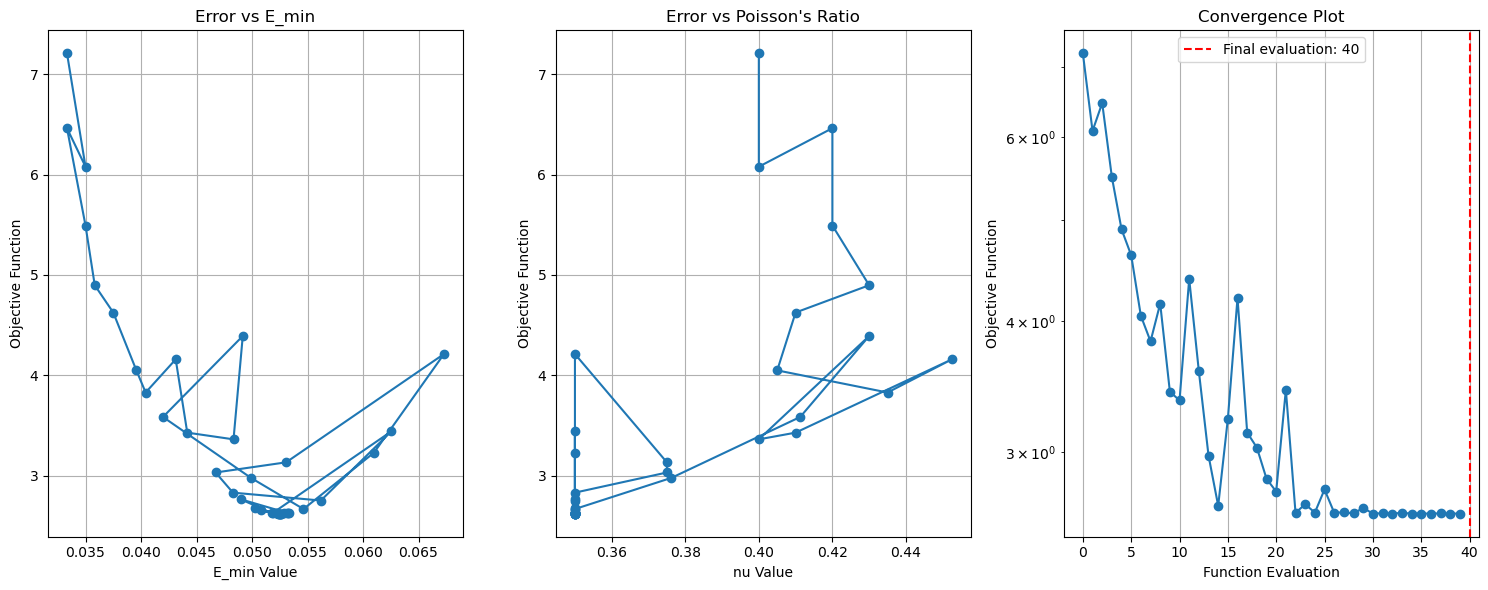

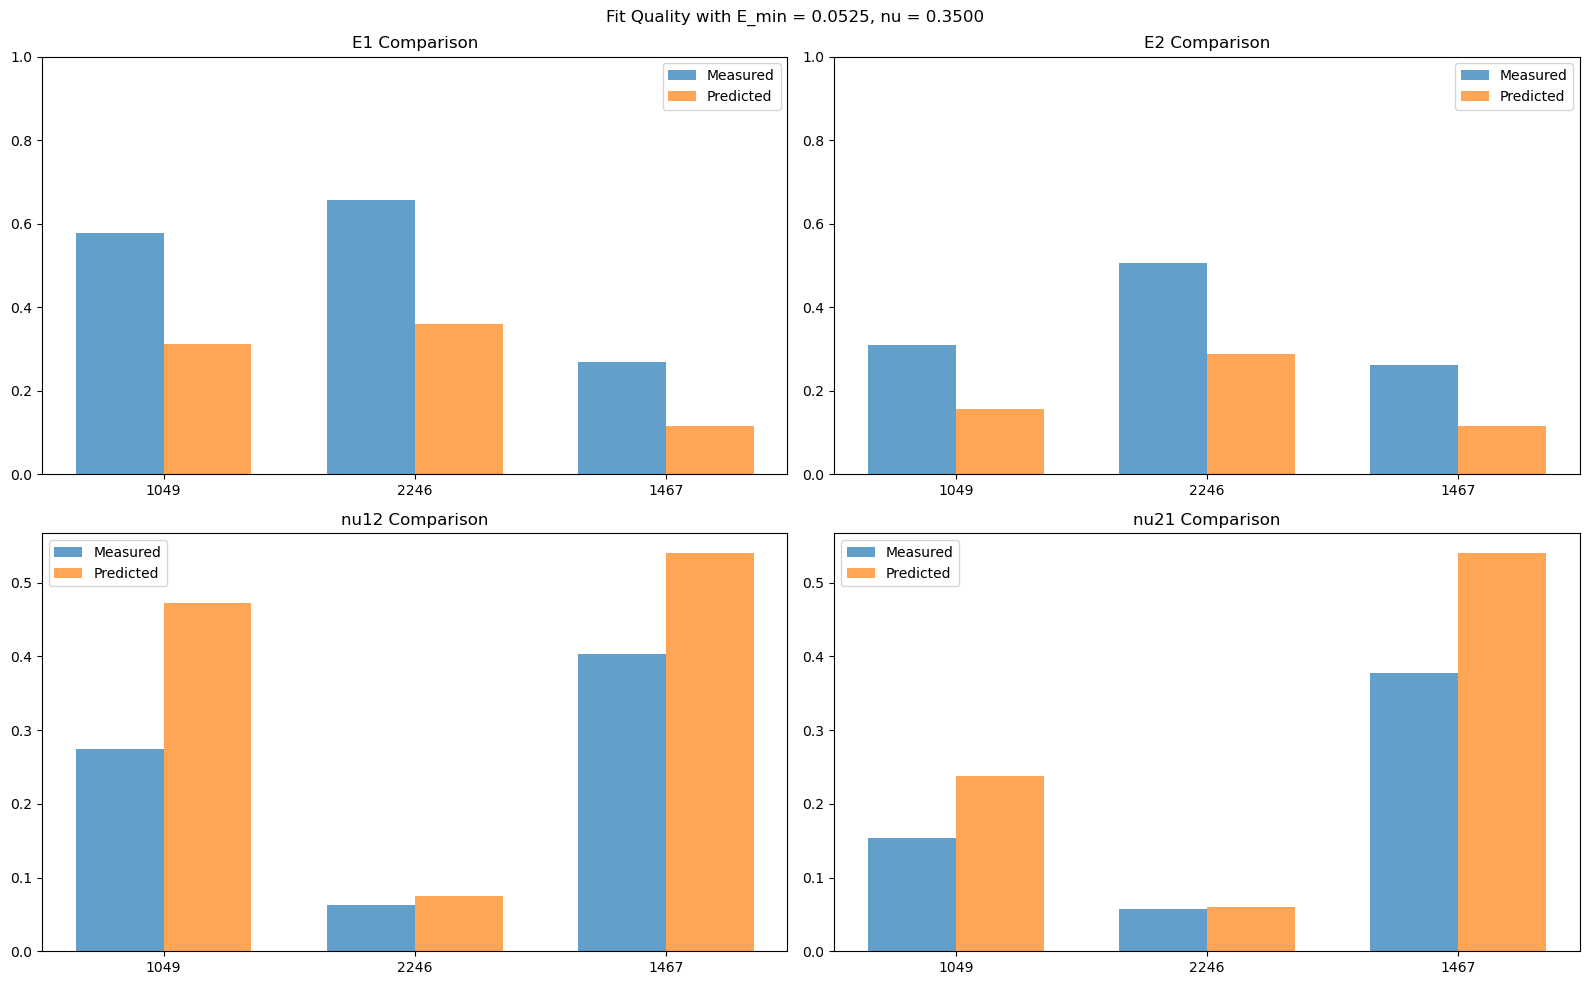

In [42]:
# Post-run Analysis =====================================
# Plot the objective function over runs
plt.figure(figsize=(15, 6))
E_mins = [x[0] for x in obj_history]
nus = [x[1] for x in obj_history]
errors = [x[2] for x in obj_history]

# Plot 1: Error vs E_min
plt.subplot(1, 3, 1)
plt.plot(E_mins, errors, 'o-')
plt.xlabel('E_min Value')
plt.ylabel('Objective Function')
plt.title('Error vs E_min')
plt.grid(True)

# Plot 2: Error vs nu
plt.subplot(1, 3, 2)
plt.plot(nus, errors, 'o-')
plt.xlabel('nu Value')
plt.ylabel('Objective Function')
plt.title('Error vs Poisson\'s Ratio')
plt.grid(True)

# Plot 3: Error vs Iteration
plt.subplot(1, 3, 3)
plt.plot(range(len(obj_history)), errors, 'o-')
plt.xlabel('Function Evaluation')
plt.ylabel('Objective Function')
plt.yscale('log')
plt.title('Convergence Plot')
plt.axvline(x=res.nfev, color='r', linestyle='--',
            label=f'Final evaluation: {res.nfev}')
plt.legend()
plt.grid(True)

plt.tight_layout()

# After optimization, record predictions with optimal parameters
results = {}
for id, data in exp_dict.items():
    data['metamaterial'].prop.E_min = opt_E
    data['metamaterial'].prop.nu = opt_nu  # Use optimized nu
    M = forward(data['metamaterial'], data['ops'], data['x'])
    props = calculate_elastic_constants(M, input_style='mandel')
    results[id] = {
        'predicted': props,
        'measured': {
            'E1': data['E1'],
            'E2': data['E2'],
            'nu12': data['nu12'],
            'nu21': data['nu21']
        }
    }

# Plot comparison for E1/E2 and nu12/nu21
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
ids = list(results.keys())
x_pos = np.arange(len(ids))
width = 0.35

# For E1
axes[0, 0].bar(x_pos - width/2, [results[id]['measured']['E1'] for id in ids],
               width=width, label='Measured', alpha=0.7)
axes[0, 0].bar(x_pos + width/2, [results[id]['predicted']['E1'] for id in ids],
               width=width, label='Predicted', alpha=0.7)
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels([str(id) for id in ids])
axes[0, 0].set_title('E1 Comparison')
axes[0, 0].legend()
axes[0, 0].set_ylim((0, 1))

# For E2
axes[0, 1].bar(x_pos - width/2, [results[id]['measured']['E2'] for id in ids],
               width=width, label='Measured', alpha=0.7)
axes[0, 1].bar(x_pos + width/2, [results[id]['predicted']['E2'] for id in ids],
               width=width, label='Predicted', alpha=0.7)
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels([str(id) for id in ids])
axes[0, 1].set_title('E2 Comparison')
axes[0, 1].legend()
axes[0, 1].set_ylim((0, 1))

# For nu12
axes[1, 0].bar(x_pos - width/2, [results[id]['measured']['nu12'] for id in ids],
               width=width, label='Measured', alpha=0.7)
axes[1, 0].bar(x_pos + width/2, [results[id]['predicted']['nu12'] for id in ids],
               width=width, label='Predicted', alpha=0.7)
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels([str(id) for id in ids])
axes[1, 0].set_title('nu12 Comparison')
axes[1, 0].legend()

# For nu21
axes[1, 1].bar(x_pos - width/2, [results[id]['measured']['nu21'] for id in ids],
               width=width, label='Measured', alpha=0.7)
axes[1, 1].bar(x_pos + width/2, [results[id]['predicted']['nu21'] for id in ids],
               width=width, label='Predicted', alpha=0.7)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels([str(id) for id in ids])
axes[1, 1].set_title('nu21 Comparison')
axes[1, 1].legend()

plt.suptitle(f'Fit Quality with E_min = {opt_E:.4f}, nu = {opt_nu:.4f}')
plt.tight_layout()